<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: center;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h1>Should This Loan be Approved or Denied ?</h1>

My attempt at creating an XGBoost data model to predict whether a loan can be approved or denied.  Some notes are given to make sense of it :).
</div>

In [3]:
filepath = "../input/should-this-loan-be-approved-or-denied/"

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
%matplotlib inline

<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
<h3>1. Load File</h3></div>

In [5]:
sba = pd.read_csv(filepath + 'SBAnational.csv',low_memory=False)
sba.head(2)

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,28-Feb-97,1997,...,N,Y,NaN,28-Feb-99,"$60,000.00",$0.00,P I F,$0.00,"$60,000.00","$48,000.00"
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410,28-Feb-97,1997,...,N,Y,NaN,31-May-97,"$40,000.00",$0.00,P I F,$0.00,"$40,000.00","$32,000.00"


<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Load file with some conversion</b>
    </div>

In [6]:
def convert(val):
    if val == np.nan:
        return 0 # or what you want
    return val

def fixvals(val):
    retval = val.replace('$','')
    retval = retval.replace(',','')
    return retval

sba = pd.read_csv(filepath + 'SBAnational.csv',\
                 converters = {'DisbursementGross':fixvals,'SBA_Appv':fixvals,\
                              'GrAppv':fixvals, 'ChgOffPrinGr':fixvals}, low_memory=False)

#sba = pd.read_csv(filepath + 'SBAnational.csv',\
#                 dtype = {'DisbursementGross':np.float64,'GrAppv':np.float64,'SBA_Appv':'float64'})

In [7]:
print("Shape of SBA : ", sba.shape)
sba[['DisbursementGross','SBA_Appv','GrAppv','ChgOffPrinGr']].head(2)

Shape of SBA :  (899164, 27)


,DisbursementGross,SBA_Appv,GrAppv,ChgOffPrinGr
0,60000.00,48000.00,60000.00,0.00
1,40000.00,32000.00,40000.00,0.00


In [8]:
sba.head(2)

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,28-Feb-97,1997,...,N,Y,NaN,28-Feb-99,60000.00,$0.00,P I F,0.00,60000.00,48000.00
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410,28-Feb-97,1997,...,N,Y,NaN,31-May-97,40000.00,$0.00,P I F,0.00,40000.00,32000.00


<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h2>2. Data Preparation</h2>
    </div>

In [9]:
sba.columns

Index(['LoanNr_ChkDgt', 'Name', 'City', 'State', 'Zip', 'Bank', 'BankState',
       'NAICS', 'ApprovalDate', 'ApprovalFY', 'Term', 'NoEmp', 'NewExist',
       'CreateJob', 'RetainedJob', 'FranchiseCode', 'UrbanRural', 'RevLineCr',
       'LowDoc', 'ChgOffDate', 'DisbursementDate', 'DisbursementGross',
       'BalanceGross', 'MIS_Status', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv'],
      dtype='object')

In [10]:
sba.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899164 entries, 0 to 899163
Data columns (total 27 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   LoanNr_ChkDgt      899164 non-null  int64  
 1   Name               899150 non-null  object 
 2   City               899134 non-null  object 
 3   State              899150 non-null  object 
 4   Zip                899164 non-null  int64  
 5   Bank               897605 non-null  object 
 6   BankState          897598 non-null  object 
 7   NAICS              899164 non-null  int64  
 8   ApprovalDate       899164 non-null  object 
 9   ApprovalFY         899164 non-null  object 
 10  Term               899164 non-null  int64  
 11  NoEmp              899164 non-null  int64  
 12  NewExist           899028 non-null  float64
 13  CreateJob          899164 non-null  int64  
 14  RetainedJob        899164 non-null  int64  
 15  FranchiseCode      899164 non-null  int64  
 16  Ur

<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h2>2.1 Convert dtype</h2>
    </div>

In [11]:
sba = sba.astype({'DisbursementGross':np.float64,'SBA_Appv':np.float64,\
                              'GrAppv':np.float64, 'ChgOffPrinGr':np.float64, 'NAICS':np.str_})

<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h2>2.2 Drop rows or columns if needed</h2>
    </div>

**Check for na's in all columns**

['Name', 'City', 'State', 'Bank', 'BankState', 'NewExist', 'RevLineCr', 'LowDoc', 'ChgOffDate', 'DisbursementDate', 'MIS_Status']


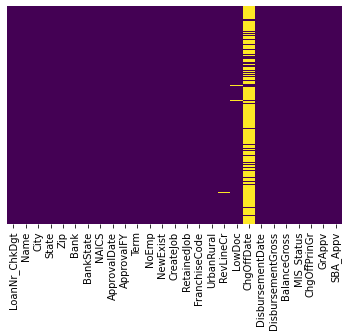

In [12]:
def check_cols_with_nulls(df):
    cols_with_missing = [col for col in df.columns if df[col].isnull().any()]
    if len(cols_with_missing) == 0:
        print("No Missing Values")
    else:
        print(cols_with_missing)
    
    sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

check_cols_with_nulls(sba)

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Column Drop 1 - drop columns deemed not needed</b>
    </div>

In [13]:
sba_save1 = sba.copy()

In [14]:
cols_to_drop = ['LoanNr_ChkDgt', 'Zip', 'Bank', 'BankState', 'ApprovalDate', 'ApprovalFY', \
                'ChgOffDate', 'BalanceGross']

sba.drop(columns=cols_to_drop, inplace=True)

In [15]:
sba.head(2)

,Name,City,State,NAICS,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementDate,DisbursementGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
0,ABC HOBBYCRAFT,EVANSVILLE,IN,451120,84,4,2.0,0,0,1,0,N,Y,28-Feb-99,60000.0,P I F,0.0,60000.0,48000.0
1,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,722410,60,2,2.0,0,0,1,0,N,Y,31-May-97,40000.0,P I F,0.0,40000.0,32000.0


<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>DisbursementDate</b>
    </div>

In [16]:
x = sba[sba['DisbursementDate'].isna()]
print(x.shape)

(2368, 19)


In [17]:
# NOt many nulls for DisbursementDate, drop rows with null
sba.dropna(subset=['DisbursementDate'], how='all', inplace=True)
x = sba[sba['DisbursementDate'].isna()]
print(x.shape)

(0, 19)


<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>RevLineCr</b></div>

In [18]:
len(sba[(sba['RevLineCr'] != 'Y') & (sba['RevLineCr'] != 'N')])

277327

In [19]:
# too many unknowns, drop 'RevlineCr'
sba.drop(columns=['RevLineCr'],inplace=True)

In [20]:
'RevLineCR' in sba.columns

False

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>LowDoc</b></div>

In [21]:
sba['LowDoc'].isna().sum()

2550

In [22]:
len(sba[(sba['LowDoc'] != 'Y') & (sba['LowDoc'] != 'N')])

5965

<AxesSubplot:xlabel='LowDoc', ylabel='count'>

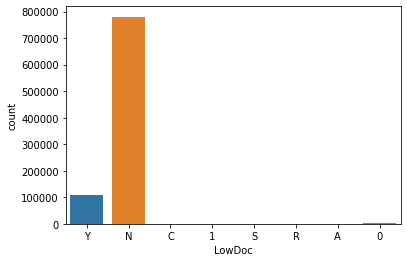

In [23]:
sns.countplot(x='LowDoc',data=sba)

In [24]:
# 5965 records that are not 'Y' or 'N', we can drop these rows as LowDoc seems to have a bearing
sba = sba[(sba['LowDoc'] == 'Y') | (sba['LowDoc'] == 'N')]
len(sba[(sba['LowDoc'] != 'Y') & (sba['LowDoc'] != 'N')])

0

In [25]:
len(sba[(sba['LowDoc'] == 'Y') | (sba['LowDoc'] == 'N')])

890831

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>NewExist</b>

In [26]:
len(sba[(sba['NewExist'] != 1) & (sba['NewExist'] != 2)])

1154

<AxesSubplot:xlabel='NewExist', ylabel='count'>

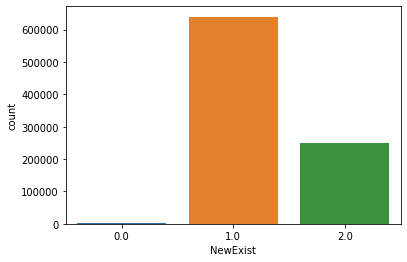

In [27]:
sns.countplot(x='NewExist',data=sba)

In [28]:
# 1154 records that are not 1 or 2, we can drop these rows as NewExist seems to have a bearing
sba = sba[(sba['NewExist'] == 1) | (sba['NewExist'] == 2)]
len(sba[(sba['NewExist'] != 1) & (sba['NewExist'] != 2)])

0

In [29]:
len(sba[(sba['NewExist'] == 1) | (sba['NewExist'] == 2)])

889677

In [30]:
# ideally, convert dtype to int32
sba = sba.astype({'NewExist':np.int32})

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>CreateJob</b></div>

In [32]:
len(sba[sba['CreateJob'].isna() == True])

0

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>RetainedJob</b></div>

In [33]:
len(sba[sba['RetainedJob'].isna() == True])

0

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>FranchiseCode</b></div>

In [34]:
len(sba[sba['FranchiseCode'].isna()])

0

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>UrbanRural</b></div>

In [35]:
print(len(sba[sba['UrbanRural'].isna()]))
sba['UrbanRural'].unique()

0


array([0, 1, 2])

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>NoEmp</b></div>

In [36]:
len(sba[sba['NoEmp'].isna()])

0

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Term</b></div>

In [37]:
print(len(sba[sba['Term'].isna()]))
print(len(sba[sba['Term']==0]))
print(len(sba[sba['Term']<0]))

0
805
0


<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>City</b></div>

In [38]:
len(sba[sba['City'].isna()])

30

In [39]:
# drop na in City column
sba = sba[sba['City'].notna()]
len(sba[sba['City'].isna()])

0

In [40]:
sba.head(2)

,Name,City,State,NAICS,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,LowDoc,DisbursementDate,DisbursementGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
0,ABC HOBBYCRAFT,EVANSVILLE,IN,451120,84,4,2,0,0,1,0,Y,28-Feb-99,60000.0,P I F,0.0,60000.0,48000.0
1,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,722410,60,2,2,0,0,1,0,Y,31-May-97,40000.0,P I F,0.0,40000.0,32000.0


In [41]:
# Trim leading and trailing spaces
sba['City'] = sba['City'].str.strip()

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>State</b></div>

In [42]:
len(sba[sba['State'].isna()])

12

In [43]:
# drop na in State column
sba = sba[sba['State'].notna()]
len(sba[sba['State'].isna()])

0

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>MIS_Status<b> - this is the **target** variable</div>

In [44]:
len(sba.loc[sba['MIS_Status'].isna()])

1795

In [45]:
# drop na in 'MIS_Status' column
sba = sba[sba['MIS_Status'].notna()]
len(sba[sba['MIS_Status'].isna()])

0

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>NAICS</b></div>

In [46]:
len(sba[sba['NAICS'].isna()])

0

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Name</b> - keeping this feature temporarily, in case it is needed
    </div>

In [47]:
len(sba[sba['Name'].isna()])

14

In [48]:
# drop rows with na in column 'Name'
sba.dropna(subset=['Name'], how='all', inplace=True)
len(sba[sba['Name'].isna()])

0

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Check for na's in all columns</b></div>

No Missing Values


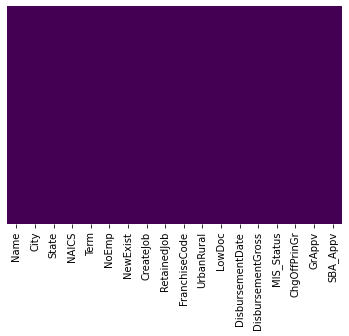

In [49]:
check_cols_with_nulls(sba)  # this function was defined earlier above

In [50]:
sba.head(2)

,Name,City,State,NAICS,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,LowDoc,DisbursementDate,DisbursementGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
0,ABC HOBBYCRAFT,EVANSVILLE,IN,451120,84,4,2,0,0,1,0,Y,28-Feb-99,60000.0,P I F,0.0,60000.0,48000.0
1,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,722410,60,2,2,0,0,1,0,Y,31-May-97,40000.0,P I F,0.0,40000.0,32000.0


<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h2>2.3 Create New Features</h2>
    </div>

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Industry</b> - The industry sector is the 1st 2 digits of NAICS
    </div>

In [51]:
sba_save2 = sba.copy()

In [52]:
sba['Industry'] = sba['NAICS'].str[0:2]
sba = sba.astype({'Industry':np.int32})

In [53]:
sba.head(2)

,Name,City,State,NAICS,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,LowDoc,DisbursementDate,DisbursementGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,Industry
0,ABC HOBBYCRAFT,EVANSVILLE,IN,451120,84,4,2,0,0,1,0,Y,28-Feb-99,60000.0,P I F,0.0,60000.0,48000.0,45
1,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,722410,60,2,2,0,0,1,0,Y,31-May-97,40000.0,P I F,0.0,40000.0,32000.0,72


In [54]:
sba['Industry'].unique()
# There is an invalid industry shown which is '0', caused by blank NAICS

array([45, 72, 62,  0, 33, 81, 23, 44, 42, 61, 53, 54, 31, 51, 71, 52, 21,
       32, 56, 48, 11, 92, 22, 49, 55], dtype=int32)

In [55]:
len(sba[sba['Industry'] == 0])
# This is a bummer, as industry sector has a big effect on a business, speaking as a business 
# domain expert.  Do we drop those with NAICS = 0 ?

200089

In [56]:
# At this stage, we leave it as is and treat it as unknown industry.  We can now drop NAICS

sba.drop(columns=['NAICS'], inplace=True)
sba.head(2)

,Name,City,State,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,LowDoc,DisbursementDate,DisbursementGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,Industry
0,ABC HOBBYCRAFT,EVANSVILLE,IN,84,4,2,0,0,1,0,Y,28-Feb-99,60000.0,P I F,0.0,60000.0,48000.0,45
1,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,60,2,2,0,0,1,0,Y,31-May-97,40000.0,P I F,0.0,40000.0,32000.0,72


In [57]:
# Check if we can impute from the name.  For example, a bar (or similar) business
sba[(sba['Name'].str.contains('bar',case=False)) & (sba['Industry'] == 0)]\
    [['Name','Industry']].head(10)

# It's not feasible, so we drop the idea.

,Name,Industry
692,DICKEY'S BARBECUE PIT,0
892,MID-STATE REBAR FABRICATORS,0
2763,"MCDUFFY'S SPORTS BAR, INC.",0
3488,PETRUCCI'S DAIRY BARN OF MARLT,0
3941,SEOUL BARBECUE RESTAURANT,0
4022,STEAMERS RAW BAR & SEA GRILLE,0
4748,QUALITY INN BARSTOW,0
7856,THE ISLANDS RAW BAR & GRILL,0
7895,SANTA BARBARA PERIPHERALS INC.,0
8047,M'S PLACE SMOKEHOUSE BARBEQUE,0


In [58]:
# We can also drop 'Name' now
sba.drop(columns='Name',inplace=True)

In [59]:
sba.head(2)

,City,State,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,LowDoc,DisbursementDate,DisbursementGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,Industry
0,EVANSVILLE,IN,84,4,2,0,0,1,0,Y,28-Feb-99,60000.0,P I F,0.0,60000.0,48000.0,45
1,NEW PARIS,IN,60,2,2,0,0,1,0,Y,31-May-97,40000.0,P I F,0.0,40000.0,32000.0,72


<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Recession</b><br>
We want to account for variation due to the Great Recession (December 2007 to June 2009). Should we separate the datasets into different time periods ? Before, During, and After ?  Let's check how large the sets are later.  In the meantime, we create a new feature, Recession, with 1 for 'Y' and 0 for 'N' depending on the DisbursementDate. 
<br><br>
</div>

In [60]:
# Convert "DisbursementDate" to datetime

sba['DisbursementDate'] = pd.to_datetime(sba['DisbursementDate'], format='%d-%b-%y')

sba.head(2)

,City,State,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,LowDoc,DisbursementDate,DisbursementGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,Industry
0,EVANSVILLE,IN,84,4,2,0,0,1,0,Y,1999-02-28,60000.0,P I F,0.0,60000.0,48000.0,45
1,NEW PARIS,IN,60,2,2,0,0,1,0,Y,1997-05-31,40000.0,P I F,0.0,40000.0,32000.0,72


In [61]:
# Create new column based on condition
sba['Recession'] = np.where((sba['DisbursementDate'] >= '2007-09-01')\
                     & (sba['DisbursementDate'] <= '2009-06-30'), 1, 0)

In [62]:
print(f'Total - {len(sba)}')
y = len(sba[sba['Recession'] == 1])
n = len(sba[sba['Recession'] == 0])
print(f'Yes - {y}')
print(f'No - {n}')
print(f'Yes and No - {y+n}')


Total - 887826
Yes - 65647
No - 822179
Yes and No - 887826


<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Real Estate</b><br>
Loans backed by real estate will have terms 20 years or greater (≥240 months) and are the only loans granted for such a long term, whereas loans not backed by real estate will have terms less than 20 years (<240 months).<br><br>
1 - Backed By Real Estate<br>
0 - Not Backed By Real Estate<br><br>

In [63]:
# Create new column based on condition
sba['RealEstate'] = np.where(sba['Term'] >= 240, 1, 0)

In [65]:
print(f'Total - {len(sba)}')
y = len(sba[sba['RealEstate'] == 1])
n = len(sba[sba['RealEstate'] == 0])
print(f'Yes - {y}')
print(f'No - {n}')
print(f'Yes and No - {y+n}')

Total - 887826
Yes - 150700
No - 737126
Yes and No - 887826


<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>SBA_Portion</b><br>
The portion which is the percentage of the loan that is guaranteed by SBA. This is derived by calculating the ratio of the amount of the loan SBA guarantees and the gross amount approved by the bank (SBA_Appv/GrAppv) * 100.<br><br></div>

In [66]:
sba['SBA_Portion']=(sba['SBA_Appv']/sba['GrAppv']) * 100
sba.head(2)

,City,State,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,LowDoc,DisbursementDate,DisbursementGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,Industry,Recession,RealEstate,SBA_Portion
0,EVANSVILLE,IN,84,4,2,0,0,1,0,Y,1999-02-28,60000.0,P I F,0.0,60000.0,48000.0,45,0,0,80.0
1,NEW PARIS,IN,60,2,2,0,0,1,0,Y,1997-05-31,40000.0,P I F,0.0,40000.0,32000.0,72,0,0,80.0


**CityState**

In [67]:
sba["CityState"] = sba["City"] + "_" + sba["State"]
sba[["CityState", "City", "State"]].head()

,CityState,City,State
0,EVANSVILLE_IN,EVANSVILLE,IN
1,NEW PARIS_IN,NEW PARIS,IN
2,BLOOMINGTON_IN,BLOOMINGTON,IN
3,BROKEN ARROW_OK,BROKEN ARROW,OK
4,ORLANDO_FL,ORLANDO,FL


In [68]:
sba.head(2)

,City,State,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,LowDoc,...,DisbursementGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,Industry,Recession,RealEstate,SBA_Portion,CityState
0,EVANSVILLE,IN,84,4,2,0,0,1,0,Y,...,60000.0,P I F,0.0,60000.0,48000.0,45,0,0,80.0,EVANSVILLE_IN
1,NEW PARIS,IN,60,2,2,0,0,1,0,Y,...,40000.0,P I F,0.0,40000.0,32000.0,72,0,0,80.0,NEW PARIS_IN


<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h2>2.4 Encode Categorical Features</h2>
    </div>

In [69]:
sba_save3 = sba.copy()

In [70]:
sba.select_dtypes(["object"]).nunique()

City          32346
State            51
LowDoc            2
MIS_Status        2
CityState     44196
dtype: int64

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>MIS_Status</b><br>
    This will be the <b>target</b> variable</div>

P I F     732244
CHGOFF    155582
Name: MIS_Status, dtype: int64


<AxesSubplot:xlabel='MIS_Status', ylabel='count'>

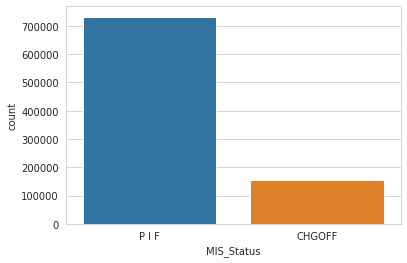

In [71]:
sns.set_style('whitegrid')
# My target variable is MIS Status, a categorical variable

print(sba['MIS_Status'].value_counts())
sns.countplot(x='MIS_Status',data=sba)

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    This shows a skewed distribution, where this bias in the target can influence many machine learning algorithms, leading some to ignore the minority class entirely, in this case, CHGOFF.  Before oversampling the data, will try as is.<br><br></div>

In [72]:
# Update column based on condition
sba['MIS_Status'] = np.where((sba['MIS_Status'] == 'P I F'), 1, 0)

In [73]:
print(sba['MIS_Status'].dtype)
sba.head(2)[['City','MIS_Status']]

int64


,City,MIS_Status
0,EVANSVILLE,1
1,NEW PARIS,1


<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>LowDoc</b><br>
'Y' = 1<br>
'N' = 0

In [74]:
# Update column based on condition
sba['LowDoc'] = np.where((sba['LowDoc'] == 'Y'), 1, 0)

sba.head(2)

,City,State,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,LowDoc,...,DisbursementGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv,Industry,Recession,RealEstate,SBA_Portion,CityState
0,EVANSVILLE,IN,84,4,2,0,0,1,0,1,...,60000.0,1,0.0,60000.0,48000.0,45,0,0,80.0,EVANSVILLE_IN
1,NEW PARIS,IN,60,2,2,0,0,1,0,1,...,40000.0,1,0.0,40000.0,32000.0,72,0,0,80.0,NEW PARIS_IN


<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Others</b></div>

In [75]:
import hashlib

cols_to_drop = []
len_data = len(sba)
for col in sba.columns:
  if sba[col].dtype == 'object':
    print(f'Column {col} has {sba[col].nunique()} values among {len_data}')

    if sba[col].nunique() < 25:
      print(f'One-hot encoding of {col}')
      one_hot_cols = pd.get_dummies(sba[col])
      for ohc in one_hot_cols.columns:
        sba[col + '_' + ohc] = one_hot_cols[ohc]
    else:
      print(f'Hashing of {col}')
      sba[col + '_hash'] = sba[col].apply(lambda row: int(hashlib.sha1((col + "_" + str(row)).encode('utf-8')).hexdigest(), 16) % len_data)

    cols_to_drop.append(col)

Column City has 32346 values among 887826
Hashing of City
Column State has 51 values among 887826
Hashing of State
Column CityState has 44196 values among 887826
Hashing of CityState


In [76]:
sba.head(2)[['City','State','CityState','City_hash','State_hash','CityState_hash']]

,City,State,CityState,City_hash,State_hash,CityState_hash
0,EVANSVILLE,IN,EVANSVILLE_IN,74511,608543,827599
1,NEW PARIS,IN,NEW PARIS_IN,274452,608543,391234


<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>TimeFrame</b><br>
Save a dataset for later use where we restrict the time frame to loans by excluding those disbursed after 2010 due to the fact the term of a loan is frequently 5 or more years.

In [77]:
sba_bef_2011 = sba[sba['DisbursementDate'] <= '2010-12-31']
len(sba_bef_2011[sba_bef_2011['DisbursementDate'] > '2010-12-31'])

0

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Drop more columns that are no longer needed<b></div>

In [78]:
sba_save4 = sba.copy()

In [79]:
sba.drop(columns = ['State', 'City','CityState','ChgOffPrinGr',\
                    'DisbursementDate'], inplace = True)  
sba.head(2)

,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,LowDoc,DisbursementGross,MIS_Status,GrAppv,SBA_Appv,Industry,Recession,RealEstate,SBA_Portion,City_hash,State_hash,CityState_hash
0,84,4,2,0,0,1,0,1,60000.0,1,60000.0,48000.0,45,0,0,80.0,74511,608543,827599
1,60,2,2,0,0,1,0,1,40000.0,1,40000.0,32000.0,72,0,0,80.0,274452,608543,391234


<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Check for Infinite Values<b></div>

In [80]:
def check_infinity_nan(df,dfname):
    print("checking for infinity")
  
    #ds = sba.isin([np.inf, -np.inf])
    #print(ds)
  
    # printing the count of infinity values
    print()
    print("printing the count of infinity values")
  
    count = np.isinf(df).values.sum()
    print(f"{dfname} contains " + str(count) + " infinite values")
    print()
    
    has_nan = df.isnull().values.any()
    print(f"Does {dfname} have Nan or Null values ?  {has_nan}")

In [81]:
check_infinity_nan(sba,'sba')

checking for infinity

printing the count of infinity values
sba contains 0 infinite values

Does sba have Nan or Null values ?  False


<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Check Correlations</b></div>

[Text(0, 0.5, 'Term'),
 Text(0, 1.5, 'NoEmp'),
 Text(0, 2.5, 'NewExist'),
 Text(0, 3.5, 'CreateJob'),
 Text(0, 4.5, 'RetainedJob'),
 Text(0, 5.5, 'FranchiseCode'),
 Text(0, 6.5, 'UrbanRural'),
 Text(0, 7.5, 'LowDoc'),
 Text(0, 8.5, 'DisbursementGross'),
 Text(0, 9.5, 'MIS_Status'),
 Text(0, 10.5, 'GrAppv'),
 Text(0, 11.5, 'SBA_Appv'),
 Text(0, 12.5, 'Industry'),
 Text(0, 13.5, 'Recession'),
 Text(0, 14.5, 'RealEstate'),
 Text(0, 15.5, 'SBA_Portion'),
 Text(0, 16.5, 'City_hash'),
 Text(0, 17.5, 'State_hash'),
 Text(0, 18.5, 'CityState_hash')]

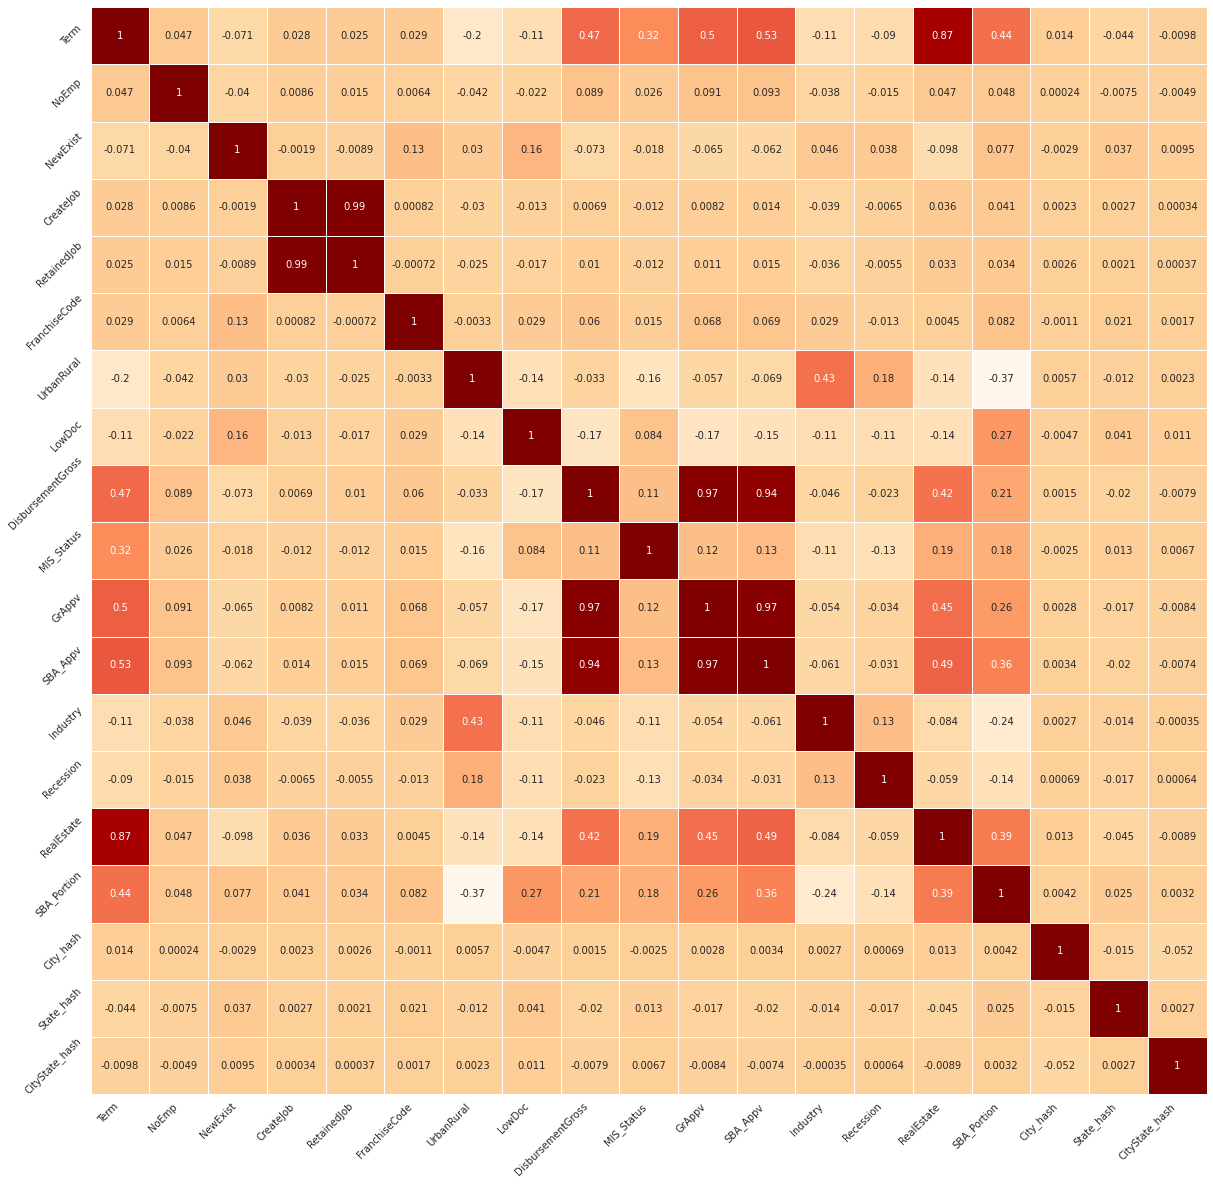

In [82]:
fig, ax = plt.subplots(figsize=(20,20))

g = sns.heatmap(
    sba.corr(),
    annot=True,
    ax=ax,
    cmap='OrRd',
    cbar=False,
    linewidth=1
)

g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
g.set_yticklabels(g.get_yticklabels(), rotation=45, horizontalalignment='right')

<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h2>3. Build Model Using XGBoost</h2>
    </div>

In [83]:
sba_save5 = sba.copy()

<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h2>3.1 Prepare Data</h2>
    </div>

In [84]:
from sklearn.model_selection import train_test_split

# Select subset of predictors
X = sba.copy()

# Select target
y = X.pop('MIS_Status')

# Separate data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.30, random_state=101)

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Metrics Function

In [85]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix

def model_eval(y_valid,predictions):
    print('MAE:', metrics.mean_absolute_error(y_valid, predictions))
    print('MSE:', metrics.mean_squared_error(y_valid, predictions))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y_valid, predictions)))
    print()
    
    print("Classification Report:")
    print(classification_report(y_valid,predictions.round()))
    print()
    
    print("\033[1m" + "Accuracy for model:\033[0m %.2f" % (accuracy_score(y_valid, \
                                                            predictions.round()) * 100))

<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h2>3.1 Model 1</h2>
    </div>

In [86]:
from xgboost import XGBRegressor

my_model1 = XGBRegressor()
my_model1.fit(X_train, y_train)

# wait a bit to complete

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [87]:
predictions = my_model1.predict(X_valid)
np.isnan(predictions).sum()

0

In [88]:
model_eval(y_valid, predictions)

MAE: 0.09995706465999162
MSE: 0.04452874618116703
RMSE: 0.21101835508118014

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.80      0.83     46761
           1       0.96      0.97      0.96    219587

    accuracy                           0.94    266348
   macro avg       0.91      0.89      0.90    266348
weighted avg       0.94      0.94      0.94    266348


Accuracy for model: 94.11


<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Improve Model 1</b></div>

In [89]:
# Separate data into training and validation sets
X_train2, X_valid2, y_train2, y_valid2 = train_test_split(X, y, test_size=0.30, \
                                                          random_state=101)

In [90]:
my_model1 = XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=4)
my_model1.fit(X_train2, y_train2, 
             early_stopping_rounds=5, 
             eval_set=[(X_valid2, y_valid2)], 
             verbose=False)

# Wait, will take time

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [91]:
# Get predictions
predictions2 = my_model1.predict(X_valid2)

In [92]:
print("\033[4m" + "After Improving Model:" + "\033[0m")
model_eval(y_valid2, predictions2)
print()

print("\033[4m" + "Before Improving Model:" + "\033[0m")
model_eval(y_valid, predictions)

After Improving Model:
MAE: 0.10117143204921232
MSE: 0.04487562796212119
RMSE: 0.21183868381889365

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.80      0.82     46761
           1       0.96      0.97      0.96    219587

    accuracy                           0.94    266348
   macro avg       0.91      0.88      0.89    266348
weighted avg       0.94      0.94      0.94    266348


Accuracy for model: 94.05

Before Improving Model:
MAE: 0.09995706465999162
MSE: 0.04452874618116703
RMSE: 0.21101835508118014

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.80      0.83     46761
           1       0.96      0.97      0.96    219587

    accuracy                           0.94    266348
   macro avg       0.91      0.89      0.90    266348
weighted avg       0.94      0.94      0.94    266348


Accuracy for model: 94.11


<div style="font-family: Trebuchet MS;background-color:HoneyDew;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Not much difference between initial build and improved build.<br><br>

Precision, recall, and f1-score of classification 0 (CHGOFF) is much lower than that of 1 (P I F). This is because MIS_Status is heavily skewed towards 1 (P I F).  To solve this, we try Oversampling the data, in the next section.</b></div>

<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h2>3.2 OverSample</h2>
    </div>

<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;"><h2>3.2.1 Model 2</h2>
    </div>

In [93]:
!pip install imbalanced-learn

In [94]:
# Select subset of predictors
X2 = sba.copy()

# Select target
y2 = X2.pop('MIS_Status')

In [95]:
from imblearn.over_sampling import RandomOverSampler

# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy='minority')

In [96]:
from collections import Counter

# fit and apply the transform
X_over, y_over = oversample.fit_resample(X2, y2)

# summarize class distribution
print('Before : ',Counter(y2))
print('After  : ',Counter(y_over))

Before :  Counter({1: 732244, 0: 155582})
After  :  Counter({1: 732244, 0: 732244})


In [97]:
# Separate data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_over, y_over, test_size=0.30, \
                                                      random_state=101)

In [98]:
from xgboost import XGBRegressor

my_model2 = XGBRegressor()
my_model2.fit(X_train, y_train)

# wait a bit to complete

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [99]:
predictions3 = my_model2.predict(X_valid)

In [100]:
model_eval(y_valid, predictions3)

MAE: 0.13067903715838913
MSE: 0.05668210051603439
RMSE: 0.23808002964556768

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93    219973
           1       0.93      0.92      0.93    219374

    accuracy                           0.93    439347
   macro avg       0.93      0.93      0.93    439347
weighted avg       0.93      0.93      0.93    439347


Accuracy for model: 92.69


<div style="font-family: Trebuchet MS;background-color:HoneyDew;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>After oversampling of the minority class (CHGOFF), class 0 (CHGOFF) now has similar precision, recall, and f1-score as class 1 (P I F)</b>

<div style="font-family: Trebuchet MS;background-color:LightSteelBlue;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Improve The Model</b></div>

In [101]:
my_model2 = XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=4)
my_model2.fit(X_train, y_train, 
             early_stopping_rounds=5, 
             eval_set=[(X_valid, y_valid)], 
             verbose=False)

# Wait a bit, will take time

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [102]:
# Get predictions
predictions4 = my_model2.predict(X_valid)

In [103]:
model_eval(y_valid, predictions4)

MAE: 0.12796215249312062
MSE: 0.05479387079909041
RMSE: 0.23408090652398458

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93    219973
           1       0.94      0.92      0.93    219374

    accuracy                           0.93    439347
   macro avg       0.93      0.93      0.93    439347
weighted avg       0.93      0.93      0.93    439347


Accuracy for model: 92.98


<div style="font-family: Trebuchet MS;background-color:HoneyDew;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>We get a tiny improvement.  I didn't try other parameters for XGBRegressor</b></div>

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

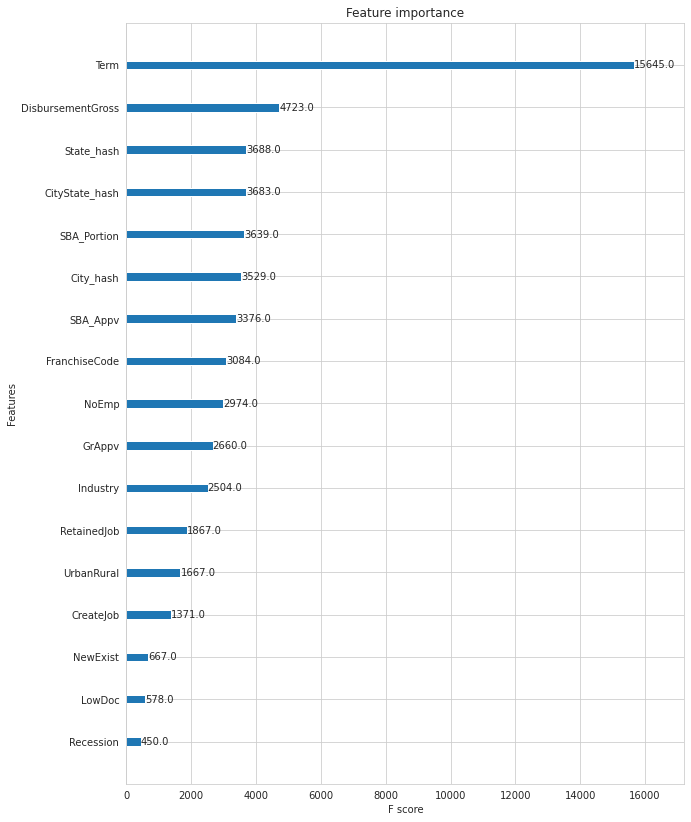

In [104]:
# Plot feature importance
from xgboost import plot_importance
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)
plot_features(my_model2, (10,14))

<div style="font-family: Trebuchet MS;background-color:HoneyDew;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Observation</b><br>
    I was hoping to see <b>Industry</b> at a much higher position here, but apparently the incomplete data on industry had an effect.<br><br>
Furthermore, <b>Recession</b> has to be at a very high position, but is at the bottom instead.  This could be due to <b>Recession</b> data being highly skewed towards 1 (Not Recession).<br><br>

<div style="font-family: Trebuchet MS;background-color:DarkCyan;color:Azure;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <h2>3.2.2 Model 3</h2>
    <b>Build a Model Dataset Excluding Year 2011 and Above</b>

We restrict the time frame to loans by excluding those disbursed after 2010 due to the fact the term of a loan is frequently 5 or more years.
       </div>

In [105]:
sba_temp = sba_bef_2011.drop(columns = ['State', 'City','CityState',\
                                        'ChgOffPrinGr','DisbursementDate']) 
print(sba_temp.columns)

# Select subset of predictors
X3 = sba_temp.copy()

# Select target
y3 = X3.pop('MIS_Status')

Index(['Term', 'NoEmp', 'NewExist', 'CreateJob', 'RetainedJob',
       'FranchiseCode', 'UrbanRural', 'LowDoc', 'DisbursementGross',
       'MIS_Status', 'GrAppv', 'SBA_Appv', 'Industry', 'Recession',
       'RealEstate', 'SBA_Portion', 'City_hash', 'State_hash',
       'CityState_hash'],
      dtype='object')


In [106]:
from imblearn.over_sampling import RandomOverSampler

# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy='minority')

In [107]:
from collections import Counter

# fit and apply the transform
X_over, y_over = oversample.fit_resample(X3, y3)

# summarize class distribution
print('Before : ',Counter(y3))
print('After  : ',Counter(y_over))

Before :  Counter({1: 714215, 0: 154479})
After  :  Counter({1: 714215, 0: 714215})


In [108]:
# Separate data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_over, y_over, test_size=0.30, \
                                                      random_state=101)

In [109]:
my_model3 = XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=4)
my_model3.fit(X_train, y_train, 
             early_stopping_rounds=5, 
             eval_set=[(X_valid, y_valid)], 
             verbose=False)

# Wait a bit, will take time

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [110]:
# Get predictions
predictions5 = my_model3.predict(X_valid)

In [111]:
model_eval(y_valid, predictions5)

MAE: 0.12625990996409162
MSE: 0.05394757451216458
RMSE: 0.23226617169136918

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93    214147
           1       0.94      0.92      0.93    214382

    accuracy                           0.93    428529
   macro avg       0.93      0.93      0.93    428529
weighted avg       0.93      0.93      0.93    428529


Accuracy for model: 93.08


<div style="font-family: Trebuchet MS;background-color:HoneyDew;color:Black;text-align: left;padding-top: 5px;padding-bottom: 5px;padding-left: 20px;padding-right: 10px;border-radius: 15px 50px;letter-spacing: 2px;">
    <b>Another tiny improvement</b></div>

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

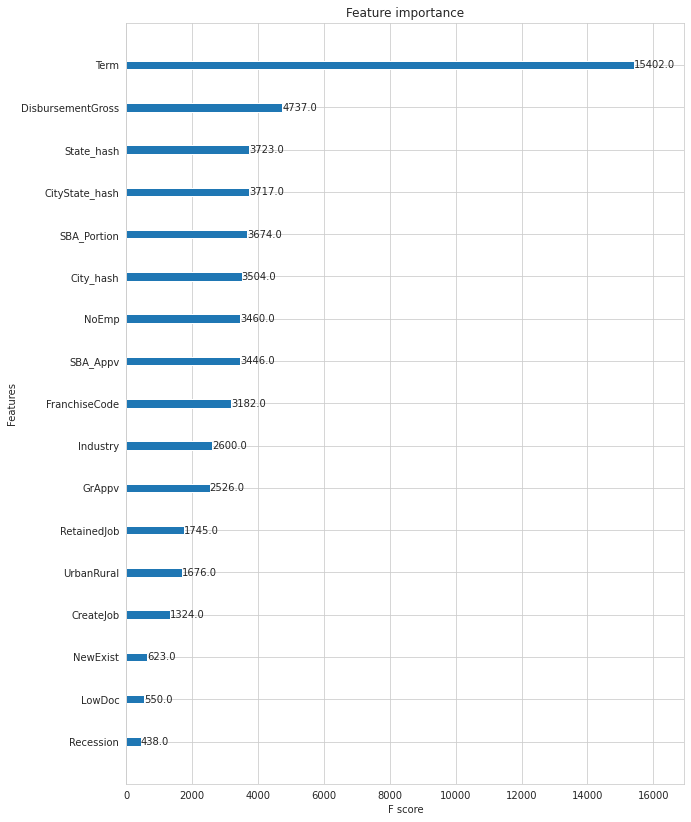

In [112]:
# Plot feature importance
from xgboost import plot_importance
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)
plot_features(my_model3, (10,14))